<a href="https://colab.research.google.com/github/AnnaSafaryan/Translator/blob/master/Training-bow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restart runtime, чтобы увидел seq2seq

In [1]:
from os import makedirs  # создание папок (в т.ч. промежуточных)
import sys
from json import dump
from keras.models import Sequential  # последовательная модель
from keras.layers import LSTM, Dense, Embedding, TimeDistributed  # слои
from keras.callbacks import ModelCheckpoint  # сохранялка
from seq2seq import Seq2Seq, AttentionSeq2Seq  # \\архитектуры seq2seq
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Курач')

In [0]:
from dater import load_config, add_config, load_data

In [0]:
from preprocessing import fit_on_texts, clean_test, show_stats, gen_to_train, gen_to_val, get_vectors

In [5]:
config = load_config(colab=True)

CONFIG
corpus_name: tatoeba
direction: en-ru
train_len: 24000
test_len: 6000
model_type: standard
epochs: 30
batch_size: 16
embed_len: 300
depth_size: 1
latent_dim: 256
corpus_len: 291172
src_len: 6
src_vocab: 3456
w2i_src: {'pdng': 0, 'unk': 1, 'finally': 2, 'kyoto': 3, 'disregarded': 4, 'christmas': 5, 'banker': 6, 'starving': 7, 'ammo': 8, 'baby': 9, 'obeyed': 10, 'relax': 11, 'proud': 12, 'grown': 13, 'sunsets': 14, 'radar': 15, 'guitar': 16, 'tripped': 17, 'bruise': 18, 'control': 19, 'retire': 20, 'sword': 21, 'signed': 22, 'bowed': 23, 'resign': 24, 'night': 25, 'son': 26, 'win': 27, 'pathetic': 28, 'students': 29, 'cross': 30, 'jazz': 31, 'freshman': 32, 'slob': 33, 'give': 34, 'enjoyed': 35, 'smells': 36, 'split': 37, 'early': 38, 'thought': 39, 'chickens': 40, 'crashed': 41, 'finish': 42, 'playing': 43, 'precious': 44, 'paged': 45, 'knit': 46, 'buried': 47, 'speechless': 48, 'cities': 49, 'grew': 50, 'koalas': 51, 'gold': 52, 'nasty': 53, 'earned': 54, 'budge': 55, 'exhausted

In [6]:
# загружаем данные
train = load_data(config['direction'], corpus_type='train', colab=True)
print(train.shape)
#print(train[:5])
train_src = train[:, 0]
train_tar = train[:, 1]

(24000, 2)


In [7]:
test = load_data(config['direction'], corpus_type='test', colab=True)
print(test.shape)
#print(test[:3])
test_src = test[:, 0]
test_tar = test[:, 1]

(6000, 2)


In [0]:
src_len, src_mlen, src_vocab, w2i_src, i2w_src = fit_on_texts(train_src)

In [0]:
tar_len, tar_mlen, tar_vocab, w2i_tar, i2w_tar = fit_on_texts(train_tar)

In [10]:
test_len, test_mlen, clean_test_src, voc_dif, pr_voc_dif, tok_dif, pr_tok_dif = clean_test(test_src, w2i_src)

Cleaning...


In [0]:
del(test_src)

In [0]:
add_config('src_len', src_len, config=config, colab=True)
add_config('src_mlen', src_mlen, config=config, colab=True)
add_config('src_vocab', src_vocab, config=config, colab=True)
add_config('w2i_src', w2i_src, config=config, colab=True)
add_config('i2w_src', i2w_src, config=config, colab=True)
add_config('tar_len', tar_len, config=config, colab=True)
add_config('tar_mlen', tar_mlen, config=config, colab=True)
add_config('tar_vocab', tar_vocab, config=config, colab=True)
add_config('w2i_tar', w2i_tar, config=config, colab=True)
add_config('i2w_tar', i2w_tar, config=config, colab=True)

In [0]:
del(w2i_src)
del(i2w_src)
del(w2i_tar)
del(i2w_tar)

In [0]:
#print(clean_test_src)

In [15]:
show_stats(config, pr_voc_dif, voc_dif, tok_dif, pr_tok_dif)


	Src maxlen:	6
	Src medlen:	3.0
	Src vocab:	3456
	Tar maxlen:	9
	Tar medlen:	3.0
	Tar vocab:	9007
	11.56% тестового словаря (233 слов) нет в тренировочном. Это 260 токенов -- 1.27% тестового корпуса.
	


In [0]:
# создаём папку для этой модели
# путь к папке с данными
data_path = '/content/gdrive/My Drive/Colab Notebooks/Курач/{}_{}_{}/e={}_b={}_d={}_h={}_emb={}'.format(config['direction'], config['model_type'], config['vec_type'], config['epochs'],
                                                       config['batch_size'], config['depth_size'], config['latent_dim'],
                                                       config['embed_len'])

In [17]:
print(data_path, '\n')
add_config('data_path', data_path,config=config,  colab=True)
try:  # пробуем создать папку
    makedirs(data_path+'/model')  # создаём цепочку папок
except OSError:  # если папка уже есть
    pass  # ничего не делаем

/content/gdrive/My Drive/Colab Notebooks/Курач/en-ru_standard_bow2/e=30_b=16_d=1_h=256_emb=300 



In [0]:
# Вывод схемы модели в файл
def sum_to_file(model):
    tmpout = sys.stdout  # сохраняем системный вывод
    fileout = open(data_path + '/' + 'summary.txt', 'w')  # переназначаем в файл
    sys.stdout = fileout
    model.summary()
    fileout.close()
    sys.stdout = tmpout  # возвращаем системный вывод

In [0]:
def vis(key, history):
    history_dict = history.history
    values = history_dict[key]
    val_values = history_dict['val_{}'.format(key)]

    epochs = range(1, len(history_dict[key]) + 1)

    plt.plot(epochs, values, 'bo', label='Training {}'.format(key))
    plt.plot(epochs, val_values, 'ro', label='Validation {}'.format(key))
    plt.title('Training and validation {}'.format(key))
    plt.xlabel('Epochs')
    plt.ylabel(key.capitalize())
    plt.legend()

    plt.show()

In [0]:
# определяем модель
def define_seq2seq_model(model_type, src_vocab, tar_vocab, src_len, tar_len, batch_size, embeddings):
    # src_vocab: объём исходного словаря
    # tar_vocab: объём конечного словаря
    # src_len: максимальная длина исходного предложения, оно же -- src_timesteps \\разве и тут будет, не только в конечных?
    # tar_len: максимальная длина конечного предложения, оно же -- tar_timesteps \\(сколько раз TimeDistributed будет "наматывать" новые слова в последовательность через Dense)

    # print("\nParams:\n model_type={} \n src_vocab={} \t tar_vocab={} \n src_len (timesteps) = {} \t tar_len (timesteps) = {}".format(model_type, src_vocab, tar_vocab, src_len, tar_len)) #\\перепиши

    # заводим последовательную модельку
    model = Sequential()

    # 1: пропускаем исходный словарь через слой Embedding \\распиши
    model.add(Embedding(src_vocab, config['embed_len'], input_length=src_len, weights=[embeddings], trainable=False))

    # 2: собственно Seq2Seq слой \\распиши
    if model_type == 'standard':
        model.add(Seq2Seq(batch_input_shape=(batch_size, src_len, config['embed_len']),
                          output_length=tar_len, output_dim=tar_vocab,
                          hidden_dim=config['latent_dim'], depth=config['depth_size'],
                          peek=False))
    elif model_type == 'peeky':
        model.add(Seq2Seq(batch_input_shape=(batch_size, src_len, config['embed_len']),
                          output_length=tar_len, output_dim=tar_vocab,
                          hidden_dim=config['latent_dim'], depth=config['depth_size'],
                          peek=True))
    elif model_type == 'attention':  # \\ValueError: Shapes must be equal rank, but are 2 and 3 for
        model.add(AttentionSeq2Seq(batch_input_shape=(batch_size, src_len, config['embed_len']),
                                   output_length=tar_len, output_dim=tar_vocab,
                                   hidden_dim=config['latent_dim'], depth=config['depth_size']))
    else:
        print(
            '\nUnknown Model Type\nModel Types:\n"standard" for Seq2Seq\n"peeky" for Seq2Seq + peek=True\n"attention" for AttentionSeq2Seq')

    # 3: слой TimeDistributed \\опиши
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))

    # компилируемся \\разбери
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['acc'])
    # optimizer: adam
    # loss: categorical_crossentropy
    
    # выводим схему модели
    model.summary()

    # plot_model(model, to_file='model.png', show_shapes=True) #\\полезная штука, разберись + что ещё умеет?
    return model

In [0]:
embed_matrix = get_vectors(config['w2i_src'], config['vec_type'], colab=True)
#embed_matrix[:10]

In [22]:
# заводим модель, указываем параметры
model = define_seq2seq_model(config['model_type'], config['src_vocab'], config['tar_vocab'], config['src_len'],
                             config['tar_len'], config['batch_size'], embed_matrix)
sum_to_file(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6, 300)            1036800   
_________________________________________________________________
model_11 (Model)             (16, 9, 9007)             14718302  
_________________________________________________________________
time_distributed_2 (TimeDist (16, 9, 9007)             81135056  
Total params: 96,890,158
Trainable params: 95,853,358
Non-trainable params: 1,036,800
_________________________________________________________________


In [23]:
train_steps = int(config['train_len'] / config['batch_size'])  # считаем шаги для генератора
print(train_steps)
add_config('train_steps', train_steps, config=config, colab=True)
test_steps = int(config['test_len'] / config['batch_size'])
print(test_steps)
add_config('test_steps', test_steps, config=config, colab=True)

1500
375


In [0]:
# обучаемся \\распиши
# \\как форматировать такое название?
checkpoint = ModelCheckpoint(data_path + '/model/' + 'weights-{epoch:1d}.h5', monitor='val_loss', verbose=1,
                             save_best_only=False, mode='min', save_weights_only=True)

In [25]:
history = model.fit_generator(gen_to_train(train_src, train_tar, config),
                    steps_per_epoch = train_steps,
                    validation_data = gen_to_val(clean_test_src, test_tar, config),
                    validation_steps = test_steps,
                    epochs=config['epochs'], callbacks=[checkpoint], verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1500/1500 [==============================] - 342s 228ms/step - loss: 2.0214 - acc: 0.0495 - val_loss: 2000.7955 - val_acc: 0.0587
Epoch 2/30
1500/1500 [==============================] - 337s 225ms/step - loss: 1.9205 - acc: 0.0490 - val_loss: 1963.5645 - val_acc: 0.0360
Epoch 3/30
1500/1500 [==============================] - 337s 225ms/step - loss: 2.5575 - acc: 0.0329 - val_loss: 2145.1670 - val_acc: 0.0357
Epoch 4/30
1500/1500 [==============================] - 337s 225ms/step - loss: 2.7934 - acc: 0.0340 - val_loss: 2194.6918 - val_acc: 0.0348
Epoch 5/30
1500/1500 [==============================] - 337s 225ms/step - loss: 2.7700 - acc: 0.0336 - val_loss: 2218.5157 - val_acc: 0.0347
Epoch 6/30
1500/1500 [==============================] - 337s 225ms/step - loss: 2.7566 - acc: 0.0337 - val_loss: 2253.0294 - val_acc: 0.0346
Epoch 7/30
1500/1500 [==============================] - 337s 225ms/step - loss: 2.7490 - acc: 0.0337 - val

In [0]:
dump(history.history, open('{}/history.json'.format(config['data_path']), 'w'))

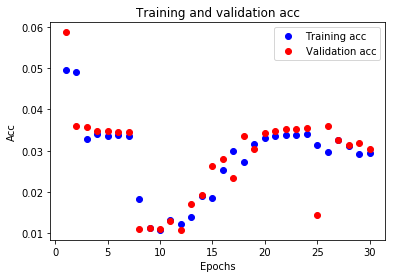

In [30]:
vis('acc', history)

In [0]:
add_config('best_epoch', 1, config=config, colab=True) #\\определять автоматически?